# DESC fringes on ExitScreen

In [1]:
import h5py;
from matplotlib import pyplot as plt
import numpy as np

import skimage.measure as sm

DAQ run with constant delay at time zero 

In [2]:
runNumber = 28495

dataDir = '/asap3/fs-flash-o/gpfs/camp/2019/data/11007673/raw/hdf/by-run/'
hdfFilename = 'FLASH1_USER1-run'+str(runNumber)+'.h5'
imagePath = '/asap3/flash/gpfs/bl1/2017/data/11003895/processed/notebooks/fig/'

print(dataDir+hdfFilename)

/asap3/fs-flash-o/gpfs/camp/2019/data/11007673/raw/hdf/by-run/FLASH1_USER1-run28495.h5


### Read Images from h5 file 

In [3]:
hdfFile = h5py.File(dataDir+hdfFilename,'r')
img = hdfFile['/uncategorised/FLASH1_USER1/FLASH.FEL/FBL1.CAM/EXIT_SCREEN/dset'].value
print(type(img),'|',img.shape)

<class 'numpy.ndarray'> | (6000, 1280, 960)


/software/anaconda3/5.2/lib/python3.6/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


###  Plot Single Image  & Crop to ROI

fig/fringe_image_1009
(500, 600)


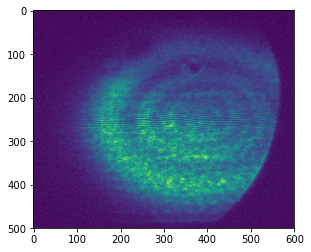

In [4]:
imgNummer = 1009

ROI_x1 = 200
ROI_x2 = 700
ROI_y1 = 100
ROI_y2 = 700

for index in range(imgNummer,imgNummer+1):
    imgName = 'fig/fringe_image_{:04d}'.format(index)
    singleImg = img[index][ROI_x1:ROI_x2,ROI_y1:ROI_y2]
    print(imgName)
    plt.clf()
    plt.imshow(singleImg)
#     plt.imsave(imgName,singleImg)

print(singleImg.shape)

## Single Image

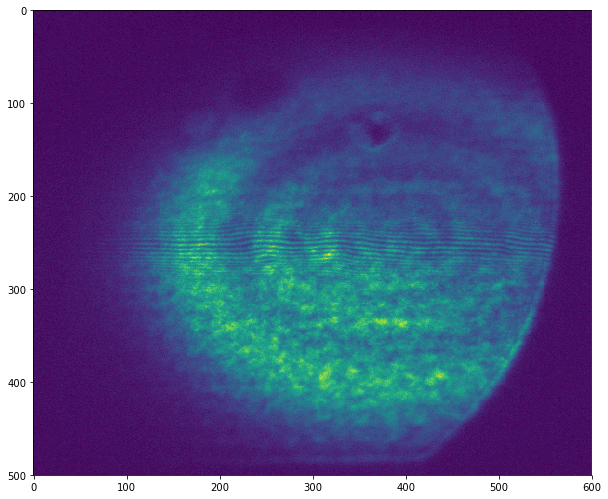

In [5]:
plt.figure(figsize=(10,10))
plt.imshow(singleImg);

## DAQ drop rate
### Integrate cropped Image

In [6]:
integral = np.asarray([np.sum(img[index][ROI_x1:ROI_x2,ROI_y1:ROI_y2]) for index in range(0,img.shape[0])])   
logicMap = (integral>25000)

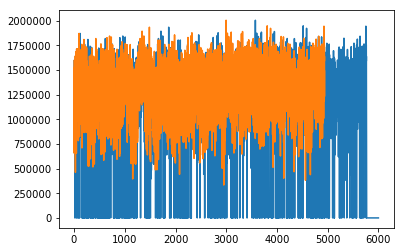

In [7]:
plt.plot(integral)
plt.plot(integral[logicMap]);

In [8]:
res = [i for i, val in enumerate(logicMap) if val]
print('Number of blanks in the end:', len(logicMap)-res[-1])
print('Acutal Rate in dataset (without appended blanks): % .3f '%(len(res)/res[-1]))

Number of blanks in the end: 236
Acutal Rate in dataset (without appended blanks):  0.857 


## Cut blanks from dataset & Crop all images to ROI

In [9]:
print('Before:',img.shape)
img = img[logicMap][:,ROI_x1:ROI_x2,ROI_y1:ROI_y2]
print('After:',img.shape)

Before: (6000, 1280, 960)
After: (4938, 500, 600)


## Average Image

In [10]:
averageImg = np.mean(img, axis = 0)
averageImg.shape

(500, 600)

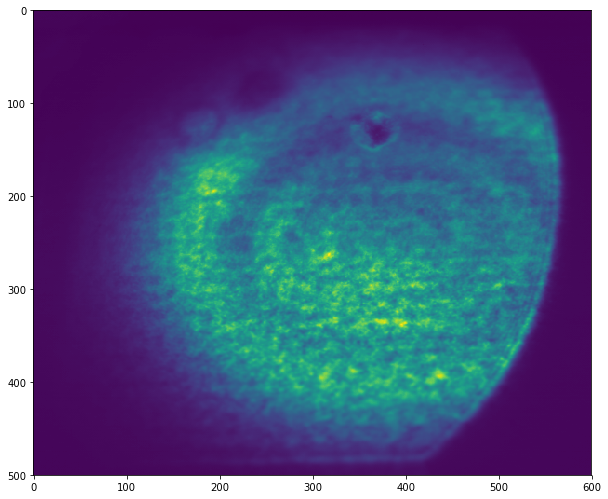

In [11]:
plt.figure(figsize=(10,10))
plt.imshow(averageImg);

### Single Image - Average Image

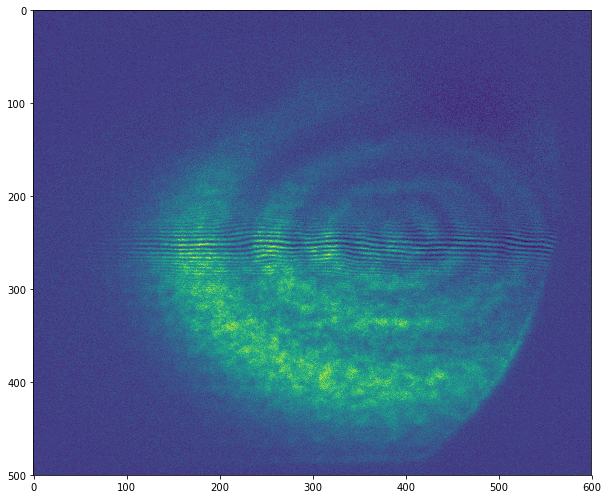

In [12]:
plt.figure(figsize=(10,10))
plt.imshow(singleImg-averageImg);

### Plot with ROI & Min/Max in ROI

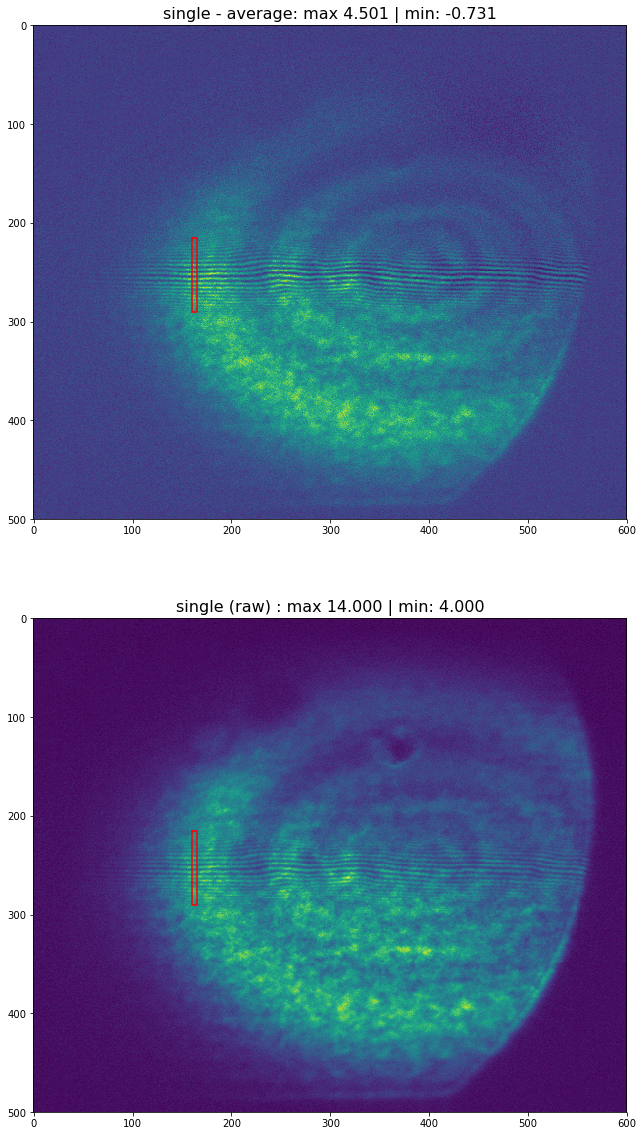

In [13]:
fringeRoiX1, fringeRoiY1 = 160, 215 
fringeRoiX2, fringeRoiY2 =  165, 290

xPlotRoi = [fringeRoiX1, fringeRoiX2, fringeRoiX2, fringeRoiX1, fringeRoiX1]
yPlotRoi = [fringeRoiY1, fringeRoiY1, fringeRoiY2, fringeRoiY2, fringeRoiY1]

shownImg = singleImg-averageImg

plt.figure(figsize=(20,20))
plt.subplot(211)
plt.imshow(shownImg)
plt.plot(xPlotRoi,yPlotRoi,'r-')
plt.title('single - average: max %0.3f | min: %0.3f'%(np.max(shownImg[fringeRoiX1:fringeRoiX2,fringeRoiY1:fringeRoiY2]),np.min(shownImg[fringeRoiX1:fringeRoiX2,fringeRoiY1:fringeRoiY2])), fontsize=16)
plt.subplot(212)
plt.imshow(singleImg)
plt.plot(xPlotRoi,yPlotRoi,'r-')
plt.title('single (raw) : max %0.3f | min: %0.3f'%(np.max(singleImg[fringeRoiX1:fringeRoiX2,fringeRoiY1:fringeRoiY2]),np.min(singleImg[fringeRoiX1:fringeRoiX2,fringeRoiY1:fringeRoiY2])), fontsize=16);



# Fringe Visibility  (by applying a Low Pass Filter) on Raw Image
## to do: Low Pass Filter

$$FV = \frac{I_{max} - I_{min}}{I_{max}+I_{min}} $$
with $$I = \frac{I_{p}}{I_{f}} $$
where $$I_{p}$$ is the intensity profile and $$I_{f}$$ a low pass filter

### Single Image with multiple pixel width

visibilities [0.36363636 0.34328358 0.31818182 0.29355609 0.29723225]


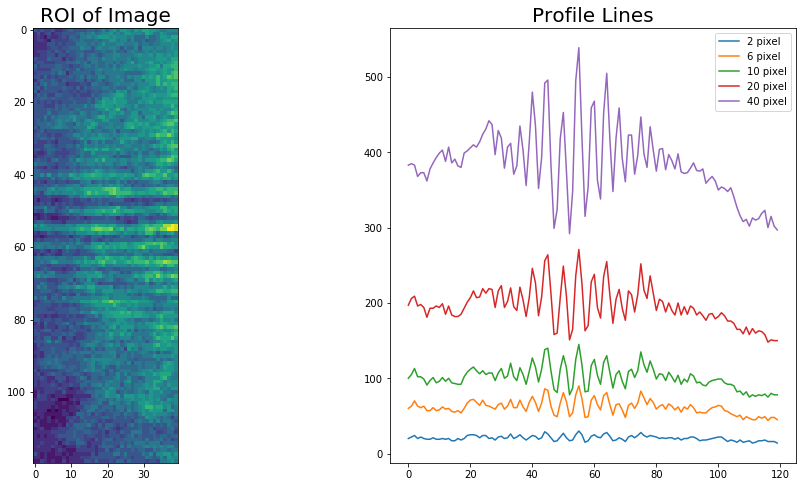

In [14]:
imgNummer = 1009
fringeRoiImage = img[imgNummer][200:320, 140:180] 

profileWidth = [2,6,10,20,40]

def extractProfileLine(integrateImage,profileWidth):
    startSum = int(integrateImage.shape[1]/2)-int(profileWidth/2)
    endSum = int(integrateImage.shape[1]/2)+int(profileWidth/2)
    return np.sum(integrateImage[:,startSum:endSum], axis=1)

def calcVisibility(profileLine):
    maxs = np.max(profileLine)
    mins = np.min(profileLine)
    return (maxs-mins)/(maxs+mins)
    
profileLines = np.asarray([extractProfileLine(fringeRoiImage, width) for width in profileWidth])
visibilities = np.asarray([calcVisibility(profileLines[index]) for index in range(0,profileLines.shape[0])])

plt.figure(figsize=(16,8))
plt.subplot(121)
plt.imshow(fringeRoiImage)
plt.title('ROI of Image', fontsize = 20)

plt.subplot(122)
[plt.plot(profileLines[index],label ='%i pixel'%profileWidth[index]) for index in range(0,profileLines.shape[0])]
plt.legend()
plt.title('Profile Lines', fontsize = 20);

print('visibilities',visibilities)

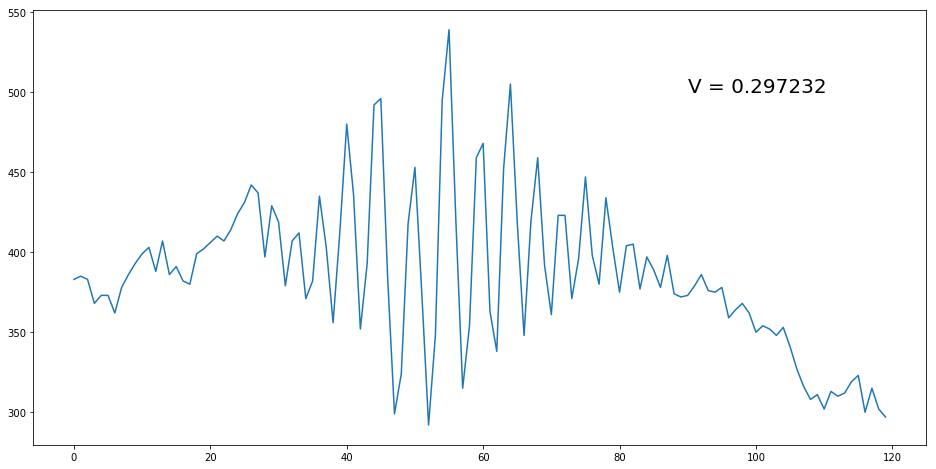

In [15]:
plt.figure(figsize=(16,8))
plt.plot(profileLines[-1])
plt.text(90,500,'V = %f'%visibilities[-1], fontsize=20);